# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood_full(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        y_correct = np.argmax(y_oh, axis=1)
        dlog = neg_log_likelihood(y_oh, y_softmax, derivative=True)
        dsoftmax = softmax(y_pred, y_oh, derivative=True)
        y_softmax[range(y_softmax.shape[0]), y_correct] = dlog[range(dlog.shape[0]), y_correct]*dsoftmax[range(dsoftmax.shape[0]), y_correct]
        return y_softmax/y_softmax.shape[0]
    return neg_log_likelihood(y_oh, y_softmax)

# Implementação 

In [7]:
class NeuralNetwork():
    def __init__(self, layers_size, activations, cost_func, learning_rate=1e-3):
        self.layers_size = layers_size
        self.activations = activations
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self._activ_inp = []
        self._activ_out = []
        self.weights = [np.random.randn(out, inp) for inp, out in zip(self.layers_size[:-1], self.layers_size[1:])]
        self.biases = [np.random.randn(1, out) for out in self.layers_size[1:]]
            
    def fit(self, x, y, epochs=100, verbose=10):
        for epoch in range(epochs+1):
            y_pred = self.__feedforward(x)
            self.__backprop(y, y_pred)
            
            if epoch % verbose == 0:
                cost = self.cost_func(y, y_pred)
                print("epoch: {0:=4}/{1} cost: {2:.8f}".format(epoch, epochs, cost))
    
    def predict(self, x):
        return self.__feedforward(x)
    
    def __feedforward(self, x):
        self._activ_inp, self._activ_out = [], []
        self._activ_out.append(x)
        for w, b, activation in zip(self.weights, self.biases, self.activations):
            y = np.dot(self._activ_out[-1], w.T) + b
            self._activ_inp.append(y)
            self._activ_out.append(activation(y))
        return self._activ_out[-1]
    
    def __backprop(self, y, y_pred):
        self._activ_out.pop()
        
        last_delta = self.cost_func(y, y_pred, derivative=True)
        dweights, dbiases = [], []
        for inp, out, w, activation in zip(self._activ_inp[::-1], self._activ_out[::-1], self.weights[::-1], self.activations[::-1]):
            dactivation = activation(inp, derivative=True)*last_delta
            last_delta = np.dot(dactivation, w)
            dweights.append(np.dot(dactivation.T, out))
            dbiases.append(1.0*dactivation.sum(axis=0, keepdims=True))
        
        self.weights = [w - self.learning_rate*dw for w, dw in zip(self.weights, reversed(dweights))]
        self.biases  = [b - self.learning_rate*db for b, db in zip(self.biases, reversed(dbiases))]

# Testes da Implementação

## Exemplos do Notebook da Intuição

### Exemplo 1

In [8]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 2], activations=[sigmoid, sigmoid], cost_func=mse, learning_rate=0.5)

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]])
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

nn.weights = [w1, w2]
nn.biases = [b1, b2]

nn.fit(x, y, epochs=0, verbose=1)

for w in nn.weights:
    print(w)

epoch:    0/0 cost: 0.29837111
[[ 0.14978072  0.19956143]
 [ 0.24975114  0.29950229]]
[[ 0.35891648  0.40866619]
 [ 0.51130127  0.56137012]]


### Exemplo 2

In [9]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])

D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 3, 3, 3], activations=[relu, sigmoid, linear], cost_func=softmax_neg_log_likelihood_full, learning_rate=0.01)

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

nn.weights = [w1, w2, w3]
nn.biases = [b1, b2, b3]

nn.fit(x, y, epochs=300, verbose=30)

for w in nn.weights:
    print(w)

epoch:    0/300 cost: 1.16744561
epoch:   30/300 cost: 0.60797958
epoch:   60/300 cost: 0.36558760
epoch:   90/300 cost: 0.24943452
epoch:  120/300 cost: 0.18547915
epoch:  150/300 cost: 0.14614615
epoch:  180/300 cost: 0.11990516
epoch:  210/300 cost: 0.10131084
epoch:  240/300 cost: 0.08751844
epoch:  270/300 cost: 0.07691721
epoch:  300/300 cost: 0.06853445
[[ 0.10083595  0.2016719   0.30585165]
 [ 0.30086971  0.20173942  0.70608796]
 [ 0.40145052  0.30290104  0.91015363]]
[[ 0.20544723  0.30673159  0.50749567]
 [ 0.30994562  0.5123005   0.71366784]
 [ 0.61065514  0.41317913  0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

In [10]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [11]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 1.0


epoch:    0/1000 cost: 5735.60801239
epoch:  100/1000 cost: 31.49110320
epoch:  200/1000 cost: 26.20715021
epoch:  300/1000 cost: 26.08576840
epoch:  400/1000 cost: 26.08298004
epoch:  500/1000 cost: 26.08291599
epoch:  600/1000 cost: 26.08291452
epoch:  700/1000 cost: 26.08291448
epoch:  800/1000 cost: 26.08291448
epoch:  900/1000 cost: 26.08291448
epoch: 1000/1000 cost: 26.08291448
[array([[ 33.60164744]])]
[array([[ 74.99636286]])]


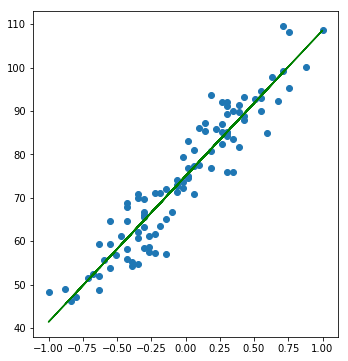

In [12]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 1], activations=[linear], cost_func=mse, learning_rate=1e-3)
nn.fit(x, y, epochs=1000, verbose=100)

print(nn.weights)
print(nn.biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [13]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [14]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [ 1.  1.  1.]


In [15]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 1], activations=[linear], cost_func=mse, learning_rate=1e-2)
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.weights)
print(nn.biases)

epoch:    0/2000 cost: 26626.42095621
epoch:  200/2000 cost: 6.83778108
epoch:  400/2000 cost: 5.82602180
epoch:  600/2000 cost: 5.74795198
epoch:  800/2000 cost: 5.73909357
epoch: 1000/2000 cost: 5.73797353
epoch: 1200/2000 cost: 5.73782874
epoch: 1400/2000 cost: 5.73780995
epoch: 1600/2000 cost: 5.73780751
epoch: 1800/2000 cost: 5.73780719
epoch: 2000/2000 cost: 5.73780715
[array([[  8.72092361,  14.1052057 ,  26.26732756]])]
[array([[ 150.6517332]])]


### Regressão Quadrática

In [16]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [17]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 2138.12401996
epoch: 1000/10000 cost: 114.62259177
epoch: 2000/10000 cost: 48.45140870
epoch: 3000/10000 cost: 37.44150217
epoch: 4000/10000 cost: 33.16395329
epoch: 5000/10000 cost: 31.14884840
epoch: 6000/10000 cost: 30.09192544
epoch: 7000/10000 cost: 29.47377247
epoch: 8000/10000 cost: 29.07863483
epoch: 9000/10000 cost: 28.80953702
epoch: 10000/10000 cost: 28.61741023


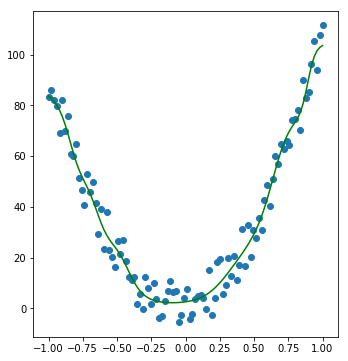

In [18]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 10, 10, 1], activations=[tanh, tanh, linear], cost_func=mse, learning_rate=1e-5)
nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [19]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [20]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 107.71926842
epoch: 1000/10000 cost: 51.19501812
epoch: 2000/10000 cost: 14.81762064
epoch: 3000/10000 cost: 6.23603008
epoch: 4000/10000 cost: 4.32572080
epoch: 5000/10000 cost: 3.61925411
epoch: 6000/10000 cost: 3.22668966
epoch: 7000/10000 cost: 2.97313014
epoch: 8000/10000 cost: 2.80469378
epoch: 9000/10000 cost: 2.69108397
epoch: 10000/10000 cost: 2.61220581


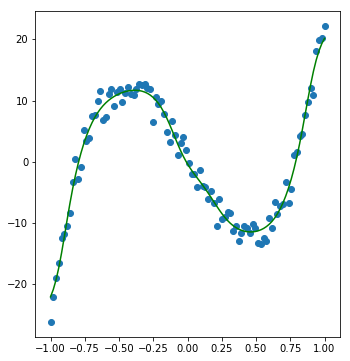

In [21]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 10, 10, 1], activations=[tanh, tanh, linear], cost_func=mse, learning_rate=1e-5)
nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [22]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [23]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 5.68613301
epoch: 1000/10000 cost: 0.07001236
epoch: 2000/10000 cost: 0.05568475
epoch: 3000/10000 cost: 0.04745925
epoch: 4000/10000 cost: 0.04273774
epoch: 5000/10000 cost: 0.04004804
epoch: 6000/10000 cost: 0.03832769
epoch: 7000/10000 cost: 0.03715966
epoch: 8000/10000 cost: 0.03633982
epoch: 9000/10000 cost: 0.03574733
epoch: 10000/10000 cost: 0.03530587


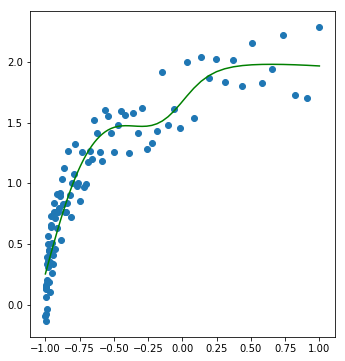

In [24]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 10, 10, 1], activations=[tanh, tanh, linear], cost_func=mse, learning_rate=1e-4)
nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [25]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [26]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 2055.07483395
epoch: 1000/10000 cost: 23.54310667
epoch: 2000/10000 cost: 22.86038765
epoch: 3000/10000 cost: 22.62555599
epoch: 4000/10000 cost: 22.29040963
epoch: 5000/10000 cost: 22.16839648
epoch: 6000/10000 cost: 22.06275801
epoch: 7000/10000 cost: 22.00886988
epoch: 8000/10000 cost: 21.95952670
epoch: 9000/10000 cost: 21.90064200
epoch: 10000/10000 cost: 21.85422213


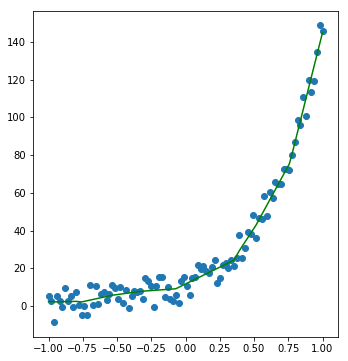

In [27]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 10, 10, 1], activations=[relu, relu, linear], cost_func=mse, learning_rate=1e-5)
nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [28]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 cost: 0.73712278
epoch: 1000/5000 cost: 0.04590319
epoch: 2000/5000 cost: 0.03112315
epoch: 3000/5000 cost: 0.02493821
epoch: 4000/5000 cost: 0.02135606
epoch: 5000/5000 cost: 0.01895587
[array([[ 7.27965363,  7.27965363]])] [array([[-11.00701121]])]
[[  1.65847362e-05]
 [  2.34912069e-02]
 [  2.34912069e-02]
 [  9.72139680e-01]]


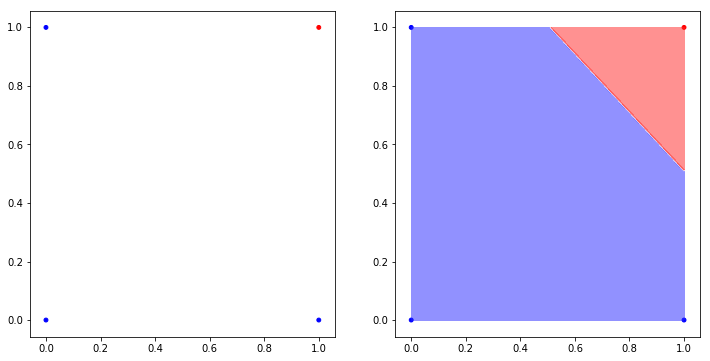

In [29]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 1], activations=[sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.fit(x, y, epochs=5000, verbose=1000)

print(nn.weights, nn.biases)
print(nn.predict(x))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

In [30]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 cost: 0.79467577
epoch: 1000/5000 cost: 0.05303208
epoch: 2000/5000 cost: 0.03075901
epoch: 3000/5000 cost: 0.02356726
epoch: 4000/5000 cost: 0.01975059
epoch: 5000/5000 cost: 0.01730646
[[ 0.01896387]
 [ 0.98364229]
 [ 0.98363369]
 [ 0.0169321 ]]


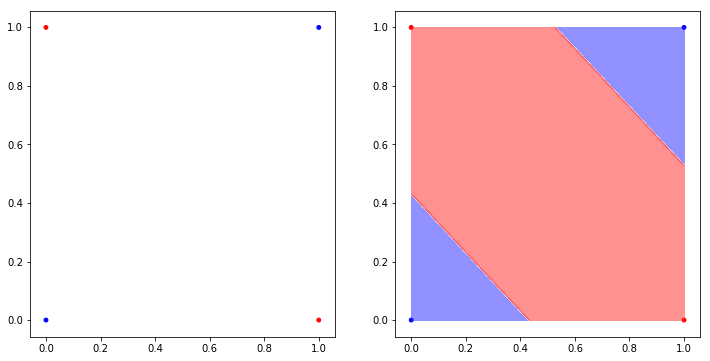

In [31]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 1], activations=[sigmoid, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1.0)

nn.fit(x, y, epochs=5000, verbose=1000)
print(nn.predict(x))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

In [32]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 cost: 1.05305540
epoch: 1000/5000 cost: 0.03472671
epoch: 2000/5000 cost: 0.02382381
epoch: 3000/5000 cost: 0.01902857
epoch: 4000/5000 cost: 0.01618426
epoch: 5000/5000 cost: 0.01425207


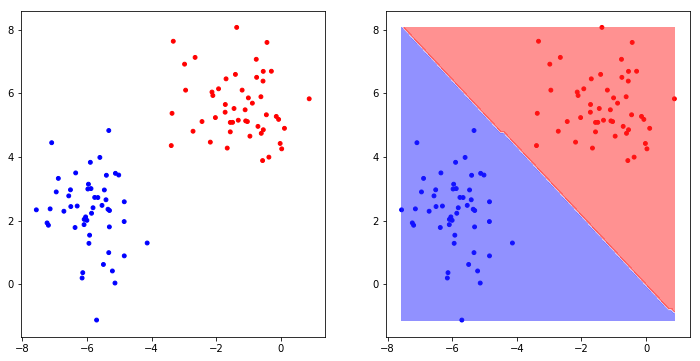

In [33]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 1], activations=[sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3)

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 4 Clusters

In [34]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/5000 cost: 0.75964140
epoch: 1000/5000 cost: 0.11398288
epoch: 2000/5000 cost: 0.04382354
epoch: 3000/5000 cost: 0.02761337
epoch: 4000/5000 cost: 0.02068992
epoch: 5000/5000 cost: 0.01684292


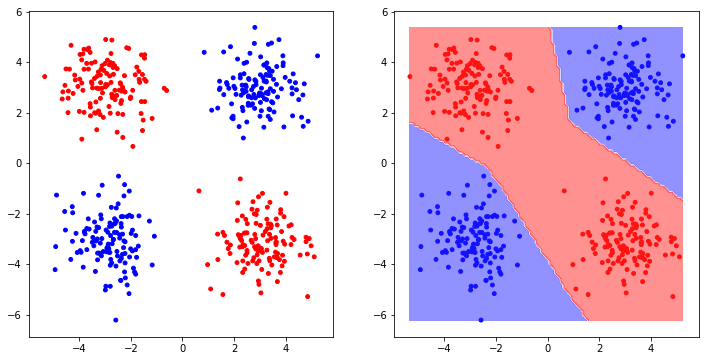

In [35]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 4, 4, 1], activations=[relu, relu, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-4)

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

In [36]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/10000 cost: 0.71300173
epoch: 1000/10000 cost: 0.02844979
epoch: 2000/10000 cost: 0.01620386
epoch: 3000/10000 cost: 0.01162439
epoch: 4000/10000 cost: 0.00918372
epoch: 5000/10000 cost: 0.00761517
epoch: 6000/10000 cost: 0.00649007
epoch: 7000/10000 cost: 0.00525656
epoch: 8000/10000 cost: 0.00451437
epoch: 9000/10000 cost: 0.00402690
epoch: 10000/10000 cost: 0.00366022


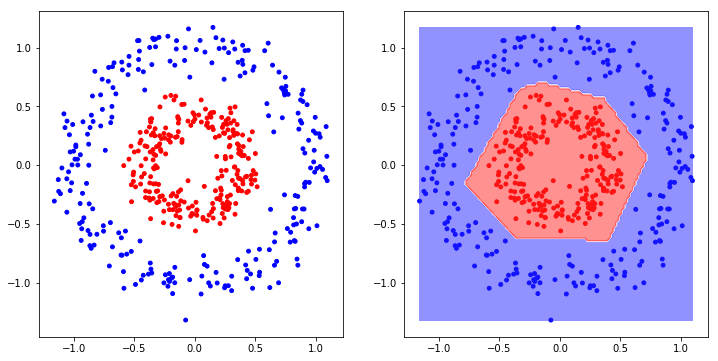

In [37]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 5, 5, 1], activations=[relu, relu, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3)

nn.fit(x, y, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

In [38]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/20000 cost: 1.19950397
epoch: 2000/20000 cost: 0.31345091
epoch: 4000/20000 cost: 0.29902998
epoch: 6000/20000 cost: 0.24022247
epoch: 8000/20000 cost: 0.17024266
epoch: 10000/20000 cost: 0.10544888
epoch: 12000/20000 cost: 0.08036747
epoch: 14000/20000 cost: 0.06867619
epoch: 16000/20000 cost: 0.06192442
epoch: 18000/20000 cost: 0.05747693
epoch: 20000/20000 cost: 0.05425592


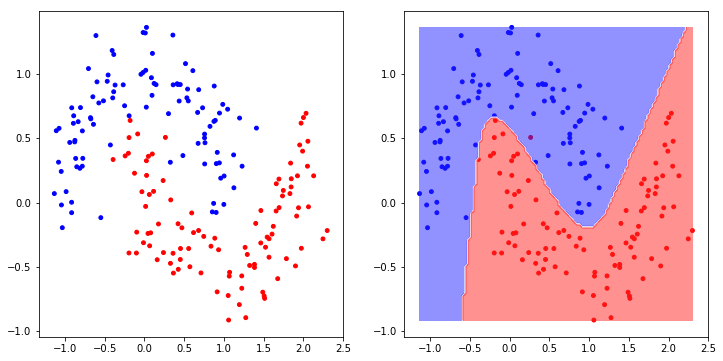

In [39]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 3, 1], activations=[tanh, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3)

nn.fit(x, y, epochs=20000, verbose=2000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

In [40]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/20000 cost: 1.02773401
epoch: 2000/20000 cost: 0.47921419
epoch: 4000/20000 cost: 0.32687954
epoch: 6000/20000 cost: 0.23063482
epoch: 8000/20000 cost: 0.17444722
epoch: 10000/20000 cost: 0.12228112
epoch: 12000/20000 cost: 0.08789455
epoch: 14000/20000 cost: 0.07086583
epoch: 16000/20000 cost: 0.06062107
epoch: 18000/20000 cost: 0.05365824
epoch: 20000/20000 cost: 0.04857285


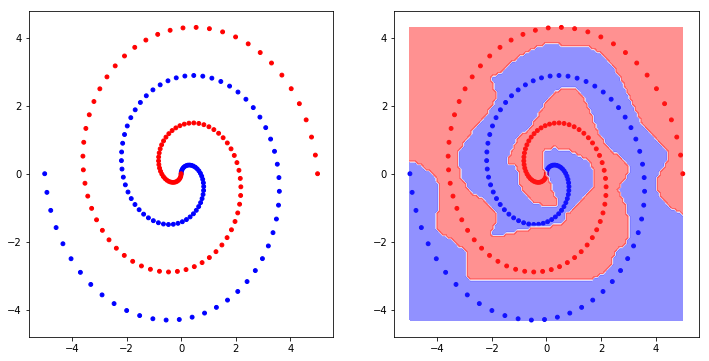

In [41]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 8, 8, 1], activations=[tanh, tanh, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3)

nn.fit(x, y, epochs=20000, verbose=2000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

In [42]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [43]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


epoch:    0/10000 cost: 1.99965937
epoch: 1000/10000 cost: 0.19691871
epoch: 2000/10000 cost: 0.09179322
epoch: 3000/10000 cost: 0.06002348
epoch: 4000/10000 cost: 0.04051683
epoch: 5000/10000 cost: 0.02925294
epoch: 6000/10000 cost: 0.02241493
epoch: 7000/10000 cost: 0.01805342
epoch: 8000/10000 cost: 0.01508223
epoch: 9000/10000 cost: 0.01293713
epoch: 10000/10000 cost: 0.01131760


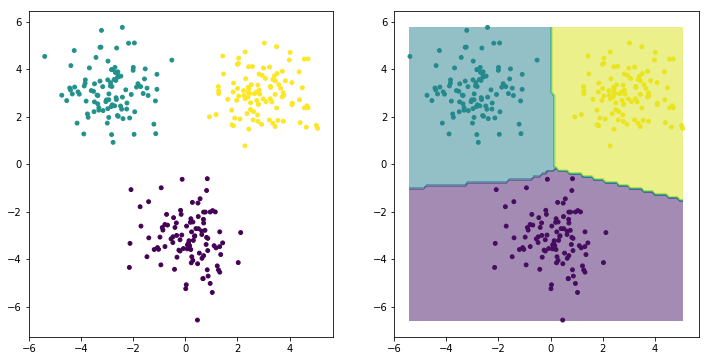

In [44]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 3], activations=[relu, linear], cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

In [45]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [46]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


epoch:    0/10000 cost: 4.64971674
epoch: 1000/10000 cost: 0.21270127
epoch: 2000/10000 cost: 0.15038237
epoch: 3000/10000 cost: 0.12500088
epoch: 4000/10000 cost: 0.11153889
epoch: 5000/10000 cost: 0.10147777
epoch: 6000/10000 cost: 0.09657088
epoch: 7000/10000 cost: 0.09351139
epoch: 8000/10000 cost: 0.09132921
epoch: 9000/10000 cost: 0.08955589
epoch: 10000/10000 cost: 0.08805791


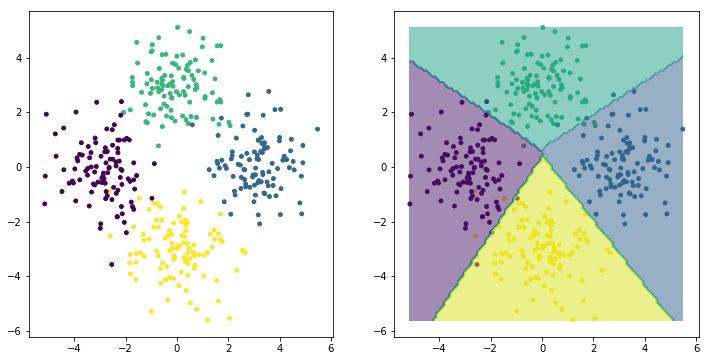

In [47]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 3, 4], activations=[relu, linear], cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

In [48]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [49]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


epoch:    0/10000 cost: 5.46969509
epoch: 1000/10000 cost: 0.24664951
epoch: 2000/10000 cost: 0.12589062
epoch: 3000/10000 cost: 0.08272904
epoch: 4000/10000 cost: 0.05832297
epoch: 5000/10000 cost: 0.04731059
epoch: 6000/10000 cost: 0.04126032
epoch: 7000/10000 cost: 0.03729696
epoch: 8000/10000 cost: 0.03448798
epoch: 9000/10000 cost: 0.03235394
epoch: 10000/10000 cost: 0.03068607


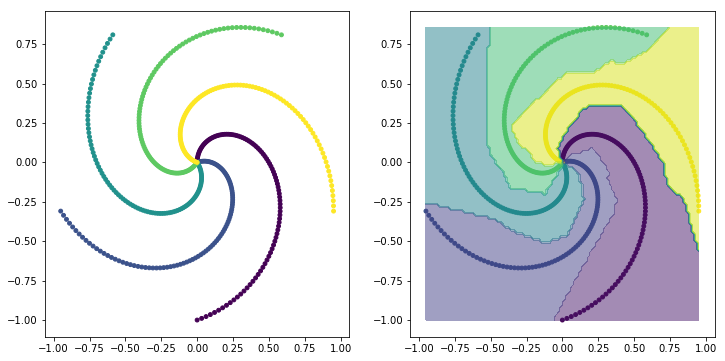

In [50]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 10, 10, 5], activations=[relu, relu, linear], cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [51]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [52]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


epoch:    0/10000 cost: 2.71753290
epoch: 1000/10000 cost: 0.52191576
epoch: 2000/10000 cost: 0.37192106
epoch: 3000/10000 cost: 0.32805413
epoch: 4000/10000 cost: 0.30615960
epoch: 5000/10000 cost: 0.29220686
epoch: 6000/10000 cost: 0.28180377
epoch: 7000/10000 cost: 0.27367282
epoch: 8000/10000 cost: 0.26666288
epoch: 9000/10000 cost: 0.26042207
epoch: 10000/10000 cost: 0.25467505


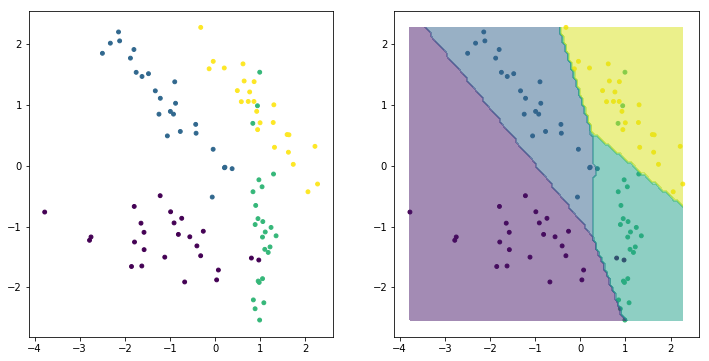

In [53]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 5, 4], activations=[relu, relu, linear], cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [54]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [55]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


epoch:    0/10000 cost: 2.33686669
epoch: 1000/10000 cost: 0.47263175
epoch: 2000/10000 cost: 0.35128142
epoch: 3000/10000 cost: 0.28185982
epoch: 4000/10000 cost: 0.23341532
epoch: 5000/10000 cost: 0.19868620
epoch: 6000/10000 cost: 0.17331328
epoch: 7000/10000 cost: 0.15431949
epoch: 8000/10000 cost: 0.13975430
epoch: 9000/10000 cost: 0.12841535
epoch: 10000/10000 cost: 0.11946986


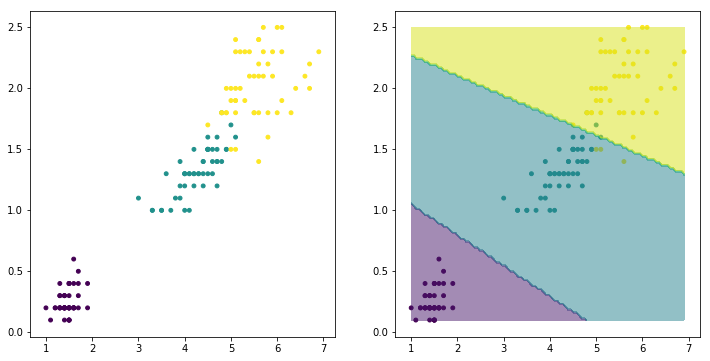

In [56]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 3], activations=[relu, linear], cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# Referências

[Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

__TODO__:
- regularização
- evitar overflow das funções de ativação
- métodos de inicialização de pesos e bias
- mini-batch SGD
- dropout
- early_stopping

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```